# clean notebook for generating scripts, submitting scripts, and plotting results

## helper funcs

In [3]:
# train/test csv file read
# automated multi-round submission & eval??? averaging??

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import subprocess
from pathlib import Path


def create_file_with_contents(file_path, contents):
    try:
        with open(file_path, 'w') as file:
            file.write(contents)
        print(f"File '{file_path}' created successfully with contents.")
    except Exception as e:
        print(f"Error: {e}")
        
def submit_job(script_path):
    output = subprocess.run(f'LLsub {script_path}', shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    return output.stdout, output.stderr

def verify_execution(log_path):
    with open(log_path) as file:
        last_line = ''
        for line in file:
            last_line = line
        return ('job done!' in last_line)
    
def verify_multiple_execution(log_paths):
    results = map(verify_execution, log_paths)
    if all(results):
        print('all scripts success!')
    else:
        failed = [i for i, x in enumerate(results) if not x]
        print(f'failed scripts: {failed}')

## single ring

#### helper funcs

In [1]:
folder = 'pareto/single_ring'

def single_ring_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'circumference':250}], 
        n_workers=40,
        n_rollouts_per_step=40, 
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=5000,
        global_reward=True,
        n_steps=50,
        alg='TRPO',
        use_critic=False,
        gamma=0.9995,
        beta=0,
        scale_ttc=1,
        scale_pet=1,
        scale_drac=1,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "worker_kwargs={worker_kwargs}" "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "warmup_steps={warmup_steps}"'''
f''' "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "global_reward={global_reward}" "n_steps={n_steps}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
f''' "scale_ttc={scale_ttc}" "scale_pet={scale_pet}" "scale_drac={scale_drac}"'''
                  )
    return script_text

def single_ring_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e='50',
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=1000,
        circumference=250,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
        scale_ttc=1,
        scale_pet=1,
        scale_drac=1,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "e={e}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "circumference={circumference}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
f''' "scale_ttc={scale_ttc}" "scale_pet={scale_pet}" "scale_drac={scale_drac}"'''
                  )
    return script_text


##### reward scaling grid search

In [4]:
reward_scaling_grid_search_exp_dir = f'{folder}/scaling_grid_search'
Path(f'{reward_scaling_grid_search_exp_dir}').mkdir(parents=True, exist_ok=True)

In [18]:
 # for scale_ttc in range(3):
 #    for scale_pet in range(3):
 #        for scale_drac in range(3):
scale_ttc, scale_pet, scale_drac = 0, 2, 2
n_steps=50*(1+scale_ttc+scale_drac+scale_pet)

b=5
beta = b/10
exp_name=f'beta{beta}_ttc{scale_ttc}_pet{scale_pet}_drac{scale_drac}_episodes{n_steps}'

cur_dir = f'{reward_scaling_grid_search_exp_dir}/{exp_name}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train_{exp_name}.log'
train_script_text = single_ring_train_script_text(
    output_log=output_log_name, 
    run_dir=cur_dir, 
    beta=beta, 
    scale_ttc=scale_ttc,
    scale_pet=scale_pet,
    scale_drac=scale_drac,
    n_steps=n_steps,
)
train_script_path = f'{cur_dir}/train_{exp_name}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)

File 'pareto/single_ring/scaling_grid_search/beta0.5_ttc0_pet2_drac2_episodes250/train_beta0.5_ttc0_pet2_drac2_episodes250.sh' created successfully with contents.


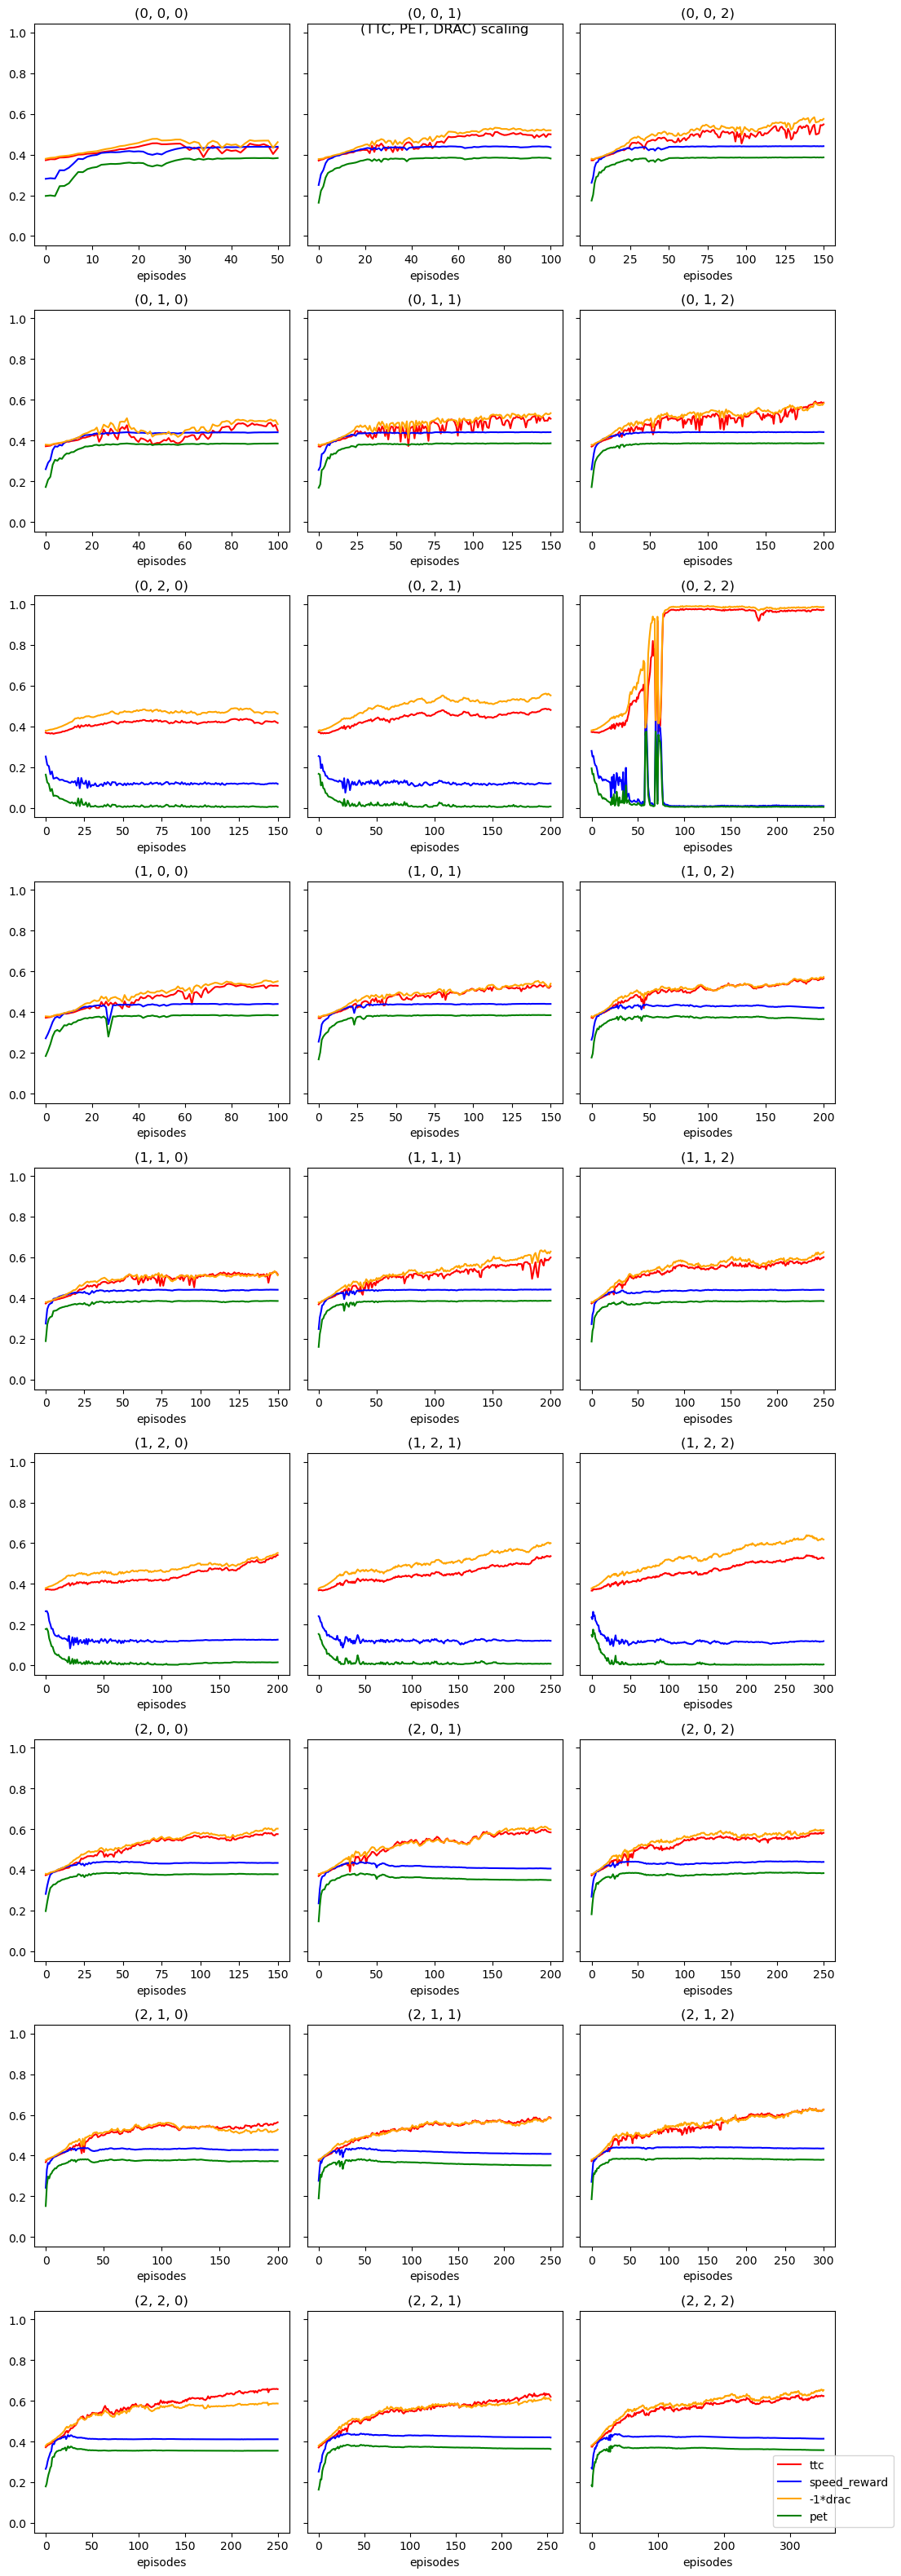

In [10]:
# graphing 3 x 3 x 3

fig, axs = plt.subplots(9, 3, figsize=(11, 32),  sharey=True)
axs_flat = axs.flatten()

for scale_ttc in range(3):
    for scale_pet in range(3):
        for scale_drac in range(3):
            n_steps=50*(1+scale_ttc+scale_drac+scale_pet)
            b=5
            beta = b/10

            exp_name=f'beta{beta}_ttc{scale_ttc}_pet{scale_pet}_drac{scale_drac}_episodes{n_steps}'
            cur_dir = f'{reward_scaling_grid_search_exp_dir}/{exp_name}'
            train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

            ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
            speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
            drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
            pet_y, pet_std = -np.log10(train_df['pet_mean']), train_df['pet_std']

            # print(train_df['pet_mean'], train_df['pet_std'])

            x = np.arange(len(speed_y))
    
            ax = axs_flat[9*scale_ttc + 3*scale_pet + 1*scale_drac]
            ax.set_title(f'({scale_ttc}, {scale_pet}, {scale_drac})')
            ax.plot(x, ttc_y, color='red', label='ttc')
            # ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
            ax.plot(x, speed_y, color='blue', label='speed_reward')
            # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_reward ± 1 std')

            ax.plot(x, drac_y, color='orange', label='-1*drac')
            # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='orange', alpha=0.2, label='-1*drac ± 1 std')
            ax.plot(x, pet_y, color='green', label='pet')
            # ax.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')

            ax.set_xlabel('episodes')

plt.suptitle('(TTC, PET, DRAC) scaling')
# axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

##### testing SSM normalizations

In [12]:
testing_all_ssms_exp_dir = f'{folder}/testing_all_ssms'
Path(f'{testing_all_ssms_exp_dir}').mkdir(parents=True, exist_ok=True)

In [53]:
b=5
beta = b/10
cur_dir = f'{testing_all_ssms_exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, n_steps=400)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/single_ring/testing_all_ssms/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25521251
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


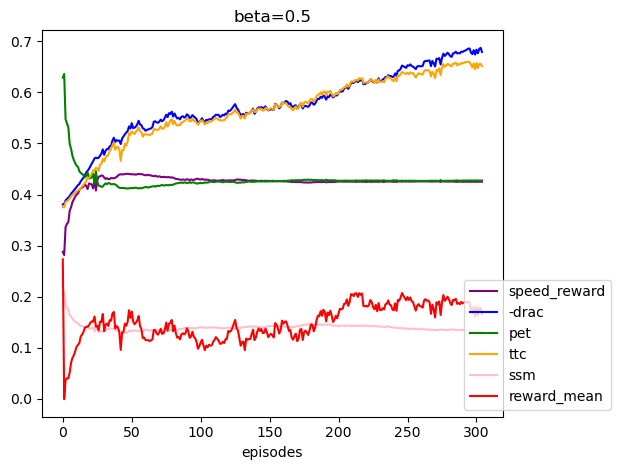

In [13]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{testing_all_ssms_exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
drac_y, drac_std = -train_df['drac_mean'], train_df['drac_std']
pet_y, pet_std = train_df['pet_mean'], train_df['pet_std']

reward_y = 100*train_df['reward_mean']

# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
ssm_y = (ttc_y+pet_y-drac_y)/3
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
# plt.plot(x, ttc_y, color='red', label='ttc')
# plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
# plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

plt.plot(x, drac_y, color='blue', label='-drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='blue', alpha=0.2, label='drac ± 1 std')
plt.plot(x, pet_y, color='green', label='pet')
# plt.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')

plt.plot(x, ttc_y, color='orange', label='ttc')
# plt.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='orange', alpha=0.2, label='ssm ± 1 std')

plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.plot(x, reward_y, color='red', label='reward_mean')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [48]:
exp_dir = f'{folder}/testing'
Path(f'{exp_dir}').mkdir(parents=True, exist_ok=True)

In [4]:

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, n_steps=1000)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/single_ring/testing/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25483459
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


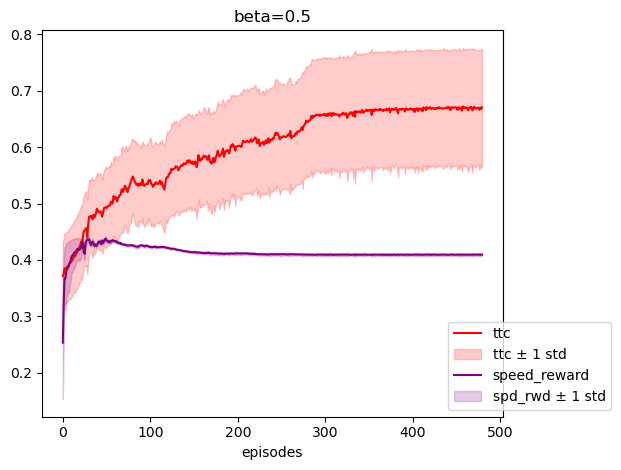

In [51]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
# drac_y, drac_std = train_df['drac_mean'], train_df['drac_std']
# ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

# plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [30]:
three_ssms_exp_dir = f'{folder}/testing_three_ssms'
Path(f'{three_ssms_exp_dir}').mkdir(parents=True, exist_ok=True)

output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{three_ssms_exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/single_ring/testing_three_ssms/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25485006
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25485007
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25485008
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25485009
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25485010
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/testing_three_ssms/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25485011
LLGrid: TXE1 (running slurm-w

In [ ]:
# verify successful train
verify_multiple_execution(output_logs) 

NameError: name 'three_ssms_exp_dir' is not defined

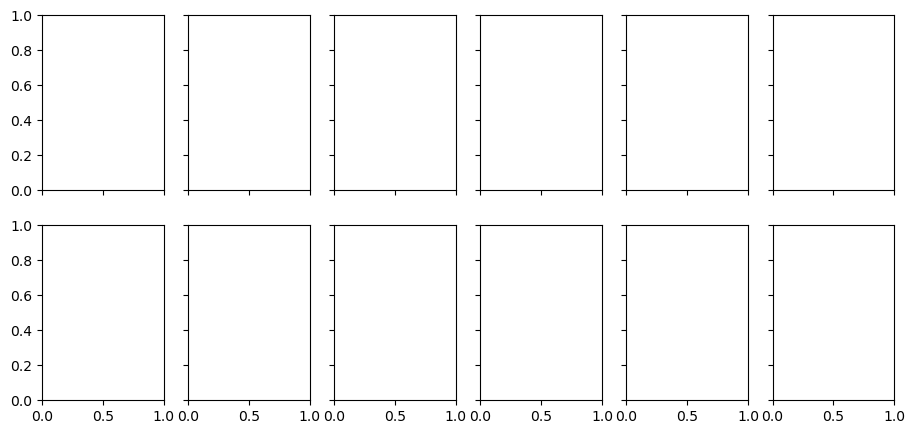

In [17]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()


for b in range(1,11):
    beta = b/10
    cur_dir = f'{three_ssms_exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
    speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
    drac_y, drac_std = 900*train_df['drac_mean'], train_df['drac_std']
    pet_y, pet_std = -np.log10(train_df['pet_mean'])/16, train_df['pet_std']
    
    # print(train_df['pet_mean'], train_df['pet_std'])
    
    x = np.arange(len(speed_y))
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_reward')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_reward ± 1 std')
    
    ax.plot(x, drac_y, color='pink', label='drac')
    ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='pink', alpha=0.2, label='drac ± 1 std')
    ax.plot(x, pet_y, color='green', label='pet')
    ax.fill_between(x, pet_y-pet_std, pet_y+pet_std, color='green', alpha=0.2, label='pet ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring TTC and speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

##### Pareto curve from scratch, all ssms

In [14]:
single_scratch_exp_dir = f'{folder}/from_scratch_all'
Path(f'{single_scratch_exp_dir}').mkdir(parents=True, exist_ok=True)

In [16]:
# train

output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{single_scratch_exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta, n_steps=350)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    output_logs += [output_log_name]
print(output_logs)

File 'pareto/single_ring/from_scratch_all/0.0/train0.0.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.1/train0.1.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.2/train0.2.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.3/train0.3.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.4/train0.4.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.5/train0.5.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.6/train0.6.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.7/train0.7.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.8/train0.8.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/0.9/train0.9.sh' created successfully with contents.
File 'pareto/single_ring/from_scratch_all/1.0/trai

In [24]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{single_scratch_exp_dir}/{beta}'
    output_log_name = f'{cur_dir}/eval{beta}.log'
    eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
    eval_script_path = f'{cur_dir}/eval{beta}.sh'
    create_file_with_contents(eval_script_path, eval_script_text)
    out, err = submit_job(eval_script_path)
    print(out, err)
    output_logs += [output_log_name]

failed scripts: []
File 'pareto/single_ring/from_scratch/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25398989
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch/0.1/eval0.1.sh' created successfully with contents.
Submitted batch job 25398990
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch/0.2/eval0.2.sh' created successfully with contents.
Submitted batch job 25398991
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch/0.3/eval0.3.sh' created successfully with contents.
Submitted batch job 25398992
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch/0.4/eval0.4.sh' created successfully with contents.
Submitted batch job 25398993
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25398994
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'par

In [12]:
b=0
beta = b/10
cur_dir = f'{single_scratch_exp_dir}/{beta}'
output_log_name = f'{cur_dir}/eval{beta}.log'
eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
eval_script_path = f'{cur_dir}/eval{beta}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)
print(out, err)

File 'pareto/single_ring/from_scratch/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25407979
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [41]:
# verify successful eval
verify_multiple_execution(output_logs)

all scripts success!


FileNotFoundError: [Errno 2] No such file or directory: 'pareto/single_ring/from_scratch_all/0.8/train_results.csv'

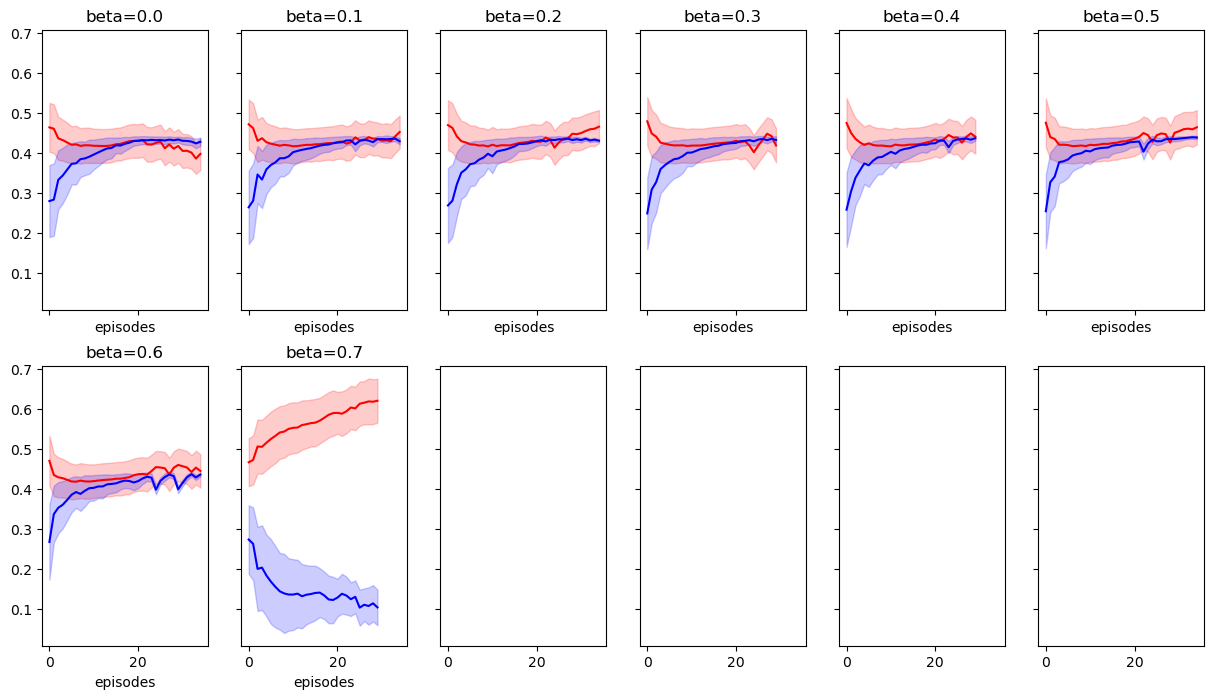

In [19]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(15, 8), sharex=True, sharey=True)
axs_flat = axs.flatten()


for b in range(11):
    beta = b/10
    cur_dir = f'{single_scratch_exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

    ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
    speed_y, speed_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
    
    x = np.arange(len(speed_y))
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ssm_y, color='red', label='ssm')
    ax.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='red', alpha=0.2, label='ssm ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_reward')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_reward ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring SSM vs Speed during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

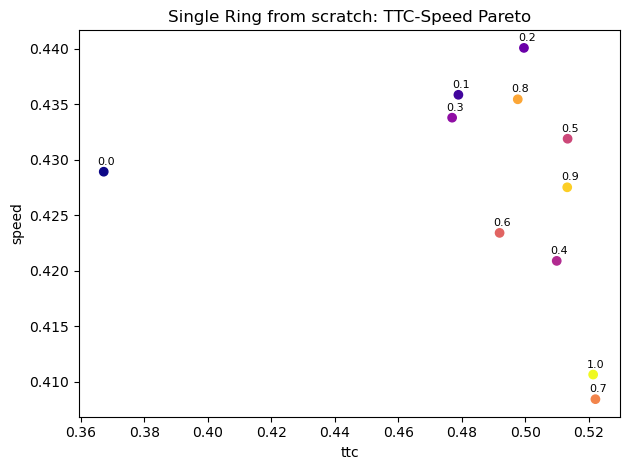

In [69]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{single_scratch_exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ssms += [np.mean(eval_df['ssm_mean'])]
    speeds += [np.mean(eval_df['speed_reward_mean'])]
    
plt.scatter(ssms, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ssms, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)

plt.title('Single Ring from scratch: SSM-Speed Pareto')
plt.xlabel('ssm')
plt.ylabel('speed')
plt.tight_layout()
plt.show()

##### Pareto curve from scratch, TTC and DRAC

In [20]:
exp_dir = f'{folder}/from_scratch_ttc_drac'
Path(f'{exp_dir}').mkdir(parents=True, exist_ok=True)

In [44]:
# testing scaling drac appropriately

b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/single_ring/from_scratch_ttc_drac/1.0/train1.0.sh' created successfully with contents.
Submitted batch job 25421799
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


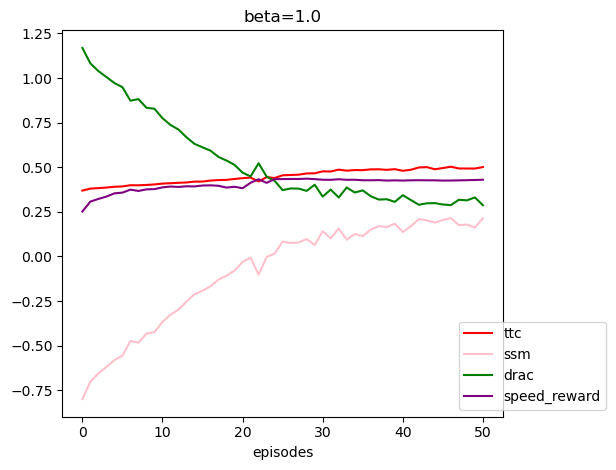

In [75]:
# plot training ttc/drac vs speed for each beta

# x = np.arange(51)

b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']

drac_y, drac_std = 3*train_df['drac_mean'], train_df['drac_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']
ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
reward_y = 100*train_df['reward_mean']

x = np.arange(len(speed_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
# plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
# plt.plot(x, speed_y, color='blue', label='speed_rl')
# plt.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.fill_between(x, ssm_y-ssm_std, ssm_y+ssm_std, color='pink', alpha=0.2, label='ssm ± 1 std')

plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
# plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [13]:
# train

output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = single_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/single_ring/from_scratch_ttc_drac/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25420822
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25420823
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25420824
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25420825
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25420826
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25420827
LLGrid: TXE

In [48]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    output_log_name = f'{cur_dir}/eval{beta}.log'
    eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
    eval_script_path = f'{cur_dir}/eval{beta}.sh'
    create_file_with_contents(eval_script_path, eval_script_text)
    out, err = submit_job(eval_script_path)
    print(out, err)
    output_logs += [output_log_name]

all scripts success!
File 'pareto/single_ring/from_scratch_ttc_drac/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25412657
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.1/eval0.1.sh' created successfully with contents.
Submitted batch job 25412658
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.2/eval0.2.sh' created successfully with contents.
Submitted batch job 25412659
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.3/eval0.3.sh' created successfully with contents.
Submitted batch job 25412660
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.4/eval0.4.sh' created successfully with contents.
Submitted batch job 25412661
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/single_ring/from_scratch_ttc_drac/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25412

In [ ]:
# verify successful eval
verify_multiple_execution(output_logs)

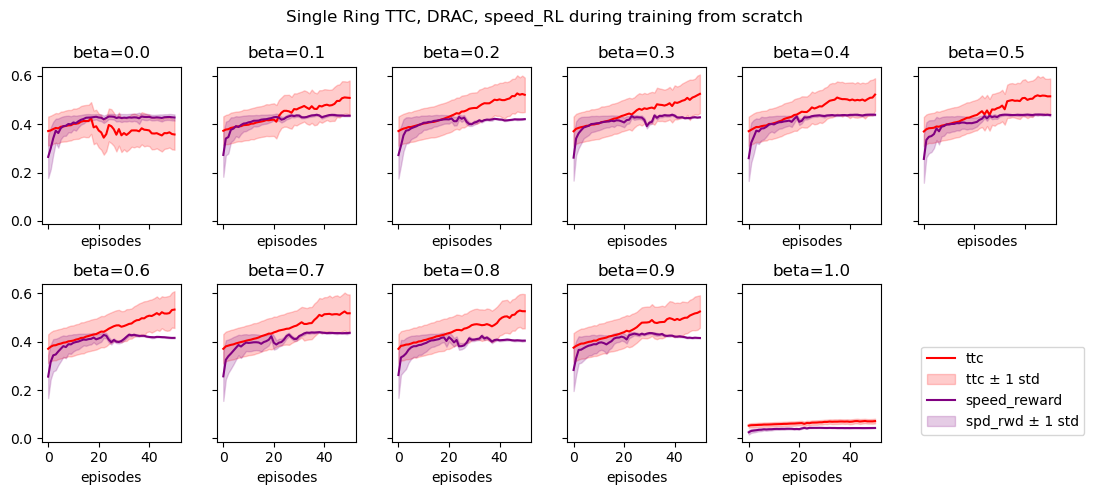

In [23]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()
x = np.arange(51)

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean']/7, train_df['ttc_std']/7
    speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
    
    drac_y, drac_std = train_df['drac_mean']*1500, train_df['drac_std']*50
    speed_reward_y, speed_reward_std = train_df['speed_reward_mean']/10, train_df['speed_reward_std']/10
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    # ax.plot(x, speed_y, color='blue', label='speed_rl')
    # ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
    
    # ax.plot(x, drac_y, color='green', label='drac')
    # ax.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
    ax.plot(x, speed_reward_y, color='purple', label='speed_reward')
    ax.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')
    
    
    ax.set_xlabel('episodes')

plt.suptitle('Single Ring TTC, DRAC, speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

In [ ]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ttcs += [np.mean(eval_df['ttc_mean'])/7]
    speeds += [np.mean(eval_df['speed_rl'])/10]
    
plt.scatter(ttcs, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ttcs, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(2,5),
                 ha='center', fontsize=8)

plt.title('Single Ring training from scratch: TTC-Speed Pareto')
plt.tight_layout()
plt.show()

##### Pareto curve from finetuning

In [79]:
# experiments/plots:
# training ttc vs speed plots of different beta vals
# naive pareto curve of different beta vals
# finetuning pareto curve of best target for each source beta val

## double ring

#### helper funcs

In [4]:
folder = 'pareto/double_ring'

def double_ring_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        n_lanes=2,
        worker_kwargs=[{'circumference':250}], 
        n_workers=40,
        n_rollouts_per_step=40, 
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=5000,
        global_reward=True,
        # n_steps=100, # default 100
        alg='TRPO',
        use_critic=False,
        gamma=0.999,
        beta=0,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "n_lanes={n_lanes}" "worker_kwargs={worker_kwargs}" "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "warmup_steps={warmup_steps}"'''
f''' "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "global_reward={global_reward}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
                  )
    return script_text

def double_ring_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e='100',
        warmup_steps=2000,
        skip_stat_steps=5000,
        horizon=1000,
        circumference=250,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/ring.py {run_dir} "e={e}" "circumference={circumference}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
                  )
    return script_text


##### Pareto curve from scratch

In [5]:
exp_dir = f'{folder}/from_scratch_ttc'
Path(f'{exp_dir}').mkdir(parents=True, exist_ok=True)

In [115]:
# train
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
    output_log_name = f'{cur_dir}/train{beta}.log'
    train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
    train_script_path = f'{cur_dir}/train{beta}.sh'
    create_file_with_contents(train_script_path, train_script_text)
    out, err = submit_job(train_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/double_ring/from_scratch/0.0/train0.0.sh' created successfully with contents.
Submitted batch job 25400884
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.1/train0.1.sh' created successfully with contents.
Submitted batch job 25400885
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.2/train0.2.sh' created successfully with contents.
Submitted batch job 25400886
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.3/train0.3.sh' created successfully with contents.
Submitted batch job 25400887
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.4/train0.4.sh' created successfully with contents.
Submitted batch job 25400888
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25400889
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ri

In [31]:
b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = double_ring_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)

File 'pareto/double_ring/from_scratch/1.0/train1.0.sh' created successfully with contents.
Submitted batch job 25408145
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [33]:
b=10
beta = b/10
cur_dir = f'{exp_dir}/{beta}'
output_log_name = f'{cur_dir}/eval{beta}.log'
eval_script_text = double_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
eval_script_path = f'{cur_dir}/eval{beta}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)
print(out, err)

File 'pareto/double_ring/from_scratch/1.0/eval1.0.sh' created successfully with contents.
Submitted batch job 25409151
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [7]:
# verify successful train
verify_multiple_execution(output_logs)
    
# eval
output_logs = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    output_log_name = f'{cur_dir}/eval{beta}.log'
    eval_script_text = double_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
    eval_script_path = f'{cur_dir}/eval{beta}.sh'
    create_file_with_contents(eval_script_path, eval_script_text)
    out, err = submit_job(eval_script_path)
    print(out, err)
    output_logs += [output_log_name]

File 'pareto/double_ring/from_scratch/0.0/eval0.0.sh' created successfully with contents.
Submitted batch job 25402866
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.1/eval0.1.sh' created successfully with contents.
Submitted batch job 25402867
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.2/eval0.2.sh' created successfully with contents.
Submitted batch job 25402868
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.3/eval0.3.sh' created successfully with contents.
Submitted batch job 25402869
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.4/eval0.4.sh' created successfully with contents.
Submitted batch job 25402870
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/from_scratch/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25402871
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 
File 'pareto/double_ring/fro

In [34]:
# verify successful eval
verify_multiple_execution(output_logs)

NameError: name 'output_logs' is not defined

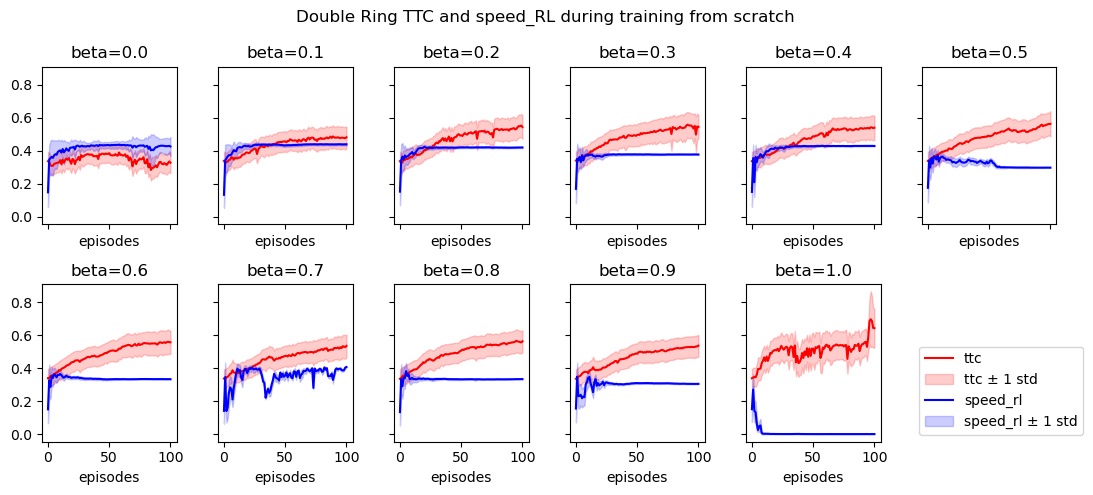

In [6]:
# plot training ttc vs speed for each beta

fig, axs = plt.subplots(2, 6, figsize=(11, 5), sharex=True, sharey=True)
axs_flat = axs.flatten()
x = np.arange(101)

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    train_df = pd.read_csv(f'{cur_dir}/train_results.csv')
    
    ttc_y, ttc_std = train_df['ttc_mean']/7, train_df['ttc_std']/7
    speed_y, speed_std = train_df['speed_rl']/10, train_df['speed_rl_std']/10
    
    ax = axs_flat[b]
    ax.set_title(f'beta={beta}')
    ax.plot(x, ttc_y, color='red', label='ttc')
    ax.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
    ax.plot(x, speed_y, color='blue', label='speed_rl')
    ax.fill_between(x, speed_y-speed_std, speed_y+speed_std, color='blue', alpha=0.2, label='speed_rl ± 1 std')
    
    ax.set_xlabel('episodes')

plt.suptitle('Double Ring TTC and speed_RL during training from scratch')
axs[-1, -1].axis('off')
legend_handles, legend_labels = axs_flat[0].get_legend_handles_labels()
plt.legend(handles=legend_handles, labels=legend_labels, loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()
plt.show()

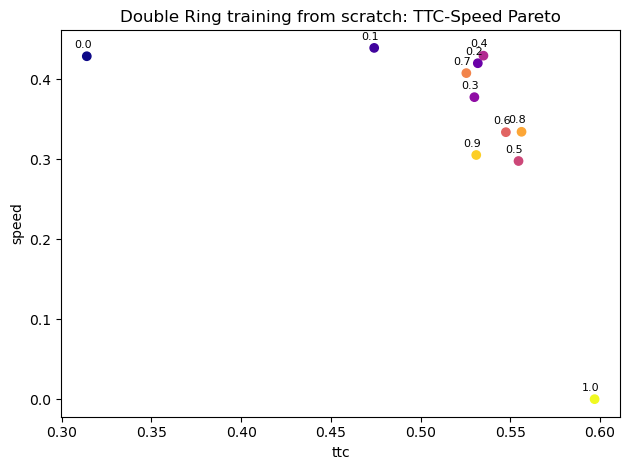

In [72]:
# plot pareto curve

ttcs = []
speeds = []

for b in range(11):
    beta = b/10
    cur_dir = f'{exp_dir}/{beta}'
    eval_df = pd.read_csv(f'{cur_dir}/eval.csv')
    
    ttcs += [np.mean(eval_df['ttc_mean'])/7]
    speeds += [np.mean(eval_df['speed_rl'])/10]
    
plt.scatter(ttcs, speeds, c=np.arange(11), cmap='plasma')

for i, (xi, yi) in enumerate(zip(ttcs, speeds)):
    plt.annotate(f'{i/10}', (xi, yi), textcoords="offset points", xytext=(-3,6),
                 ha='center', fontsize=8)

plt.title('Double Ring training from scratch: TTC-Speed Pareto')
plt.xlabel('ttc')
plt.ylabel('speed')
plt.tight_layout()
plt.show()

## figure eight

#### helper funcs

In [23]:
folder = 'pareto/figure_eight'

fe_testing_exp_dir = f'{folder}/testing'
Path(f'{fe_testing_exp_dir}').mkdir(parents=True, exist_ok=True)

def figure_eight_train_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        worker_kwargs=[{'radius':30}], 
        n_workers=40,
        n_rollouts_per_step=40,
        horizon=20000,
        lr_schedule='cosine',
        alg='TRPO',
        use_critic=False,
        gamma=0.999,
        beta=0,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/figure_eight.py {run_dir} "n_workers={n_workers}" "n_rollouts_per_step={n_rollouts_per_step}" "worker_kwargs={worker_kwargs}"'''
f''' "horizon={horizon}" "lr_schedule={lr_schedule}" "alg='{alg}'" "use_critic={use_critic}" "gamma={gamma}" "beta={beta}"'''
                  )
    return script_text

def figure_eight_eval_script_text(
        output_log='output-%j.log',
        run_dir='.', 
        e=100,
        radius=30,
        warmup_steps=1000,
        skip_stat_steps=8000,
        horizon=1000,
        n_steps=10,
        n_rollouts_per_step=1, 
        skip_vehicle_info_stat_steps=False,
        full_rollout_only=True,
        result_save='evaluations/eval.csv',
        vehicle_info_save='trajectories/trajectory.npz',
        save_agent=True,
    ): # format into script runnable on supercloud
    script_text = (f'''#!/bin/sh

#SBATCH -o {output_log}
#SBATCH --time=72:00:00          # total run time limit (HH:MM:SS)
#SBATCH -c 40

'''
f'''python $F/figure_eight.py {run_dir} "e={e}" "radius={radius}" "warmup_steps={warmup_steps}" "skip_stat_steps={skip_stat_steps}" "horizon={horizon}" "n_steps={n_steps}"'''
f''' "n_rollouts_per_step={n_rollouts_per_step}" "skip_vehicle_info_stat_steps={skip_vehicle_info_stat_steps}" "full_rollout_only={full_rollout_only}"'''
f''' "result_save={result_save}" "vehicle_info_save={vehicle_info_save}" "save_agent={save_agent}"'''
                  )
    return script_text

##### testing

In [24]:
# train

output_logs = []

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
Path(f'{cur_dir}').mkdir(parents=True, exist_ok=True)
output_log_name = f'{cur_dir}/train{beta}.log'
train_script_text = figure_eight_train_script_text(output_log=output_log_name, run_dir=cur_dir, beta=beta)
train_script_path = f'{cur_dir}/train{beta}.sh'
create_file_with_contents(train_script_path, train_script_text)
out, err = submit_job(train_script_path)
print(out, err)
output_logs += [output_log_name]

File 'pareto/figure_eight/testing/0.5/train0.5.sh' created successfully with contents.
Submitted batch job 25473778
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


In [27]:
# verify successful train
verify_multiple_execution(output_logs) 
    
# eval
output_logs = []

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
output_log_name = f'{cur_dir}/eval{beta}.log'
eval_script_text = single_ring_eval_script_text(output_log=output_log_name, run_dir=cur_dir, result_save=f'{cur_dir}/eval.csv', vehicle_info_save=f'{cur_dir}/trajectory.npz')
eval_script_path = f'{cur_dir}/eval{beta}.sh'
create_file_with_contents(eval_script_path, eval_script_text)
out, err = submit_job(eval_script_path)
print(out, err)
output_logs += [output_log_name]

failed scripts: []
File 'pareto/figure_eight/testing/0.5/eval0.5.sh' created successfully with contents.
Submitted batch job 25474813
LLGrid: TXE1 (running slurm-wlm 23.02.7)
 


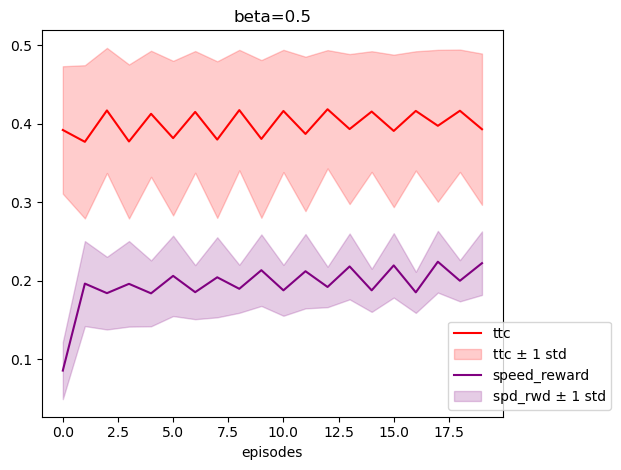

In [29]:
# plot training ttc vs speed for 0.5, see if ttc will converge

# x = np.arange(51)

b=5
beta = b/10
cur_dir = f'{fe_testing_exp_dir}/{beta}'
train_df = pd.read_csv(f'{cur_dir}/train_results.csv')

ttc_y, ttc_std = train_df['ttc_mean'], train_df['ttc_std']
speed_reward_y, speed_reward_std = train_df['speed_reward_mean'], train_df['speed_reward_std']

# speed_y, speed_std = train_df['speed_rl'], train_df['speed_rl_std']
# drac_y, drac_std = train_df['drac_mean'], train_df['drac_std']
# ssm_y = ttc_y-drac_y
# ssm_y, ssm_std = train_df['ssm_mean'], train_df['ssm_std']
# reward_y = train_df['reward_mean']

x = np.arange(len(speed_reward_y))


plt.title(f'beta={beta}')
plt.plot(x, ttc_y, color='red', label='ttc')
plt.fill_between(x, ttc_y-ttc_std, ttc_y+ttc_std, color='red', alpha=0.2, label='ttc ± 1 std')
plt.plot(x, speed_reward_y, color='purple', label='speed_reward')
plt.fill_between(x, speed_reward_y-speed_reward_std, speed_reward_y+speed_reward_std, color='purple', alpha=0.2, label='spd_rwd ± 1 std')

# plt.plot(x, ssm_y, color='pink', label='ssm')
# plt.plot(x, drac_y, color='green', label='drac')
# plt.fill_between(x, drac_y-drac_std, drac_y+drac_std, color='green', alpha=0.2, label='drac ± 1 std')
# plt.plot(x, reward_y, color='blue', label='reward')

plt.xlabel('episodes')

plt.legend(loc='lower right', bbox_to_anchor=(1.25, 0))
plt.tight_layout()

## intersection

## highway bottleneck

## highway ramp